# Run panda repeater first  
```
ssh panda@192.168.0.172
roslaunch panda_ros_repeater joint_velocity_repeater.launch robot_ip:=192.168.0.13 load_gripper:=false
```

# initialize notebook

In [1]:
from __future__ import print_function
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; } </style>"))
import matplotlib.pyplot as plt

# Initialize constants

In [2]:
from pkg.marker_config import *
from pkg.constraint_graph import *
from pkg.constraint.constraint_action import *
from pkg.constraint.constraint_object import *
from pkg.constants import *
from pkg.utils.plot_utils import *
from pkg.utils.utils import *
from pkg.environment_builder import *
from pkg.ui.ui_broker import *

gtimer = GlobalTimer.instance()
gtimer.reset()

init_stereo()
aruco_map, dictionary = get_aruco_config()

REF_NAME = 'floor'
ROBOTS_ON_SCENE = [("indy0", RobotType.indy7_robot), ("panda1", RobotType.panda_robot)]
ROBOTS_ON_SCENE_DICT = {rp[0]:rp[1] for rp in ROBOTS_ON_SCENE}
JOINT_NAMES_DEFINED = ['indy0_joint0', 'indy0_joint1', 'indy0_joint2', 'indy0_joint3', 'indy0_joint4', 'indy0_joint5',
                   'panda1_joint1', 'panda1_joint2', 'panda1_joint3', 'panda1_joint4', 
                   'panda1_joint5', 'panda1_joint6', 'panda1_joint7']
ZERO_JOINT_POSE=np.array([0,0,-np.pi/2,0,-np.pi/2,0,
                          0,-np.pi/8,0,-np.pi/2,0,np.pi/2,np.pi/2])

Start streaming
Device configuration: 
	color_format: 3 
	(0:JPG, 1:NV12, 2:YUY2, 3:BGRA32)

	color_resolution: 5 
	(0:OFF, 1:720p, 2:1080p, 3:1440p, 4:1536p, 5:2160p, 6:3072p)

	depth_mode: 3 
	(0:OFF, 1:NFOV_2X2BINNED, 2:NFOV_UNBINNED,3:WFOV_2X2BINNED, 4:WFOV_UNBINNED, 5:Passive IR)

	camera_fps: 2 
	(0:5 FPS, 1:15 FPS, 2:30 FPS)

	synchronized_images_only: False 
	(True of False). Drop images if the color and depth are not synchronized

	depth_delay_off_color_usec: 0 ms. 
	Delay between the color image and the depth image

	wired_sync_mode: 0
	(0:Standalone mode, 1:Master mode, 2:Subordinate mode)

	subordinate_delay_off_master_usec: 0 ms.
	The external synchronization timing.

	disable_streaming_indicator: False 
	(True or False). Streaming indicator automatically turns on when the color or depth camera's are in use.




# Define binding info

In [3]:
BINDER_DICT = {'goal_bd': dict(_type=PlacePlane, object_name="goal", point=[0,0,0.02], direction=[0,0,1])}
OBJECT_DICT = {'box1': dict(_type=BoxAction, hexahedral=True),
               'box2': dict(_type=BoxAction, hexahedral=True)}

# calibrate stereo

In [4]:
kn_config, rs_config, T_c12 = calibrate_stereo(aruco_map, dictionary)

# detect environment & set urdf on graph

In [5]:
xyz_rpy_robots, xyz_rvec_cams, env_gen_dict, objectPose_dict, corner_dict, color_image, rs_objectPose_dict, rs_corner_dict, rs_image  = \
    detect_environment(
        aruco_map, dictionary, robot_tuples=ROBOTS_ON_SCENE, camT_dict={"cam0":np.identity(4), "cam1": T_c12},
        ref_name=REF_NAME)

xcustom, JOINT_NAMES, LINK_NAMES, urdf_content = set_custom_robots(ROBOTS_ON_SCENE, xyz_rpy_robots, JOINT_NAMES_DEFINED)

print("wait for rviz")
time.sleep(1)

if "graph" in locals():
    graph.__init__(urdf_path=URDF_PATH, joint_names=JOINT_NAMES, link_names=LINK_NAMES, 
                   urdf_content=urdf_content, robots_on_scene=ROBOTS_ON_SCENE_DICT)
else:
    graph = ConstraintGraph(urdf_path=URDF_PATH, joint_names=JOINT_NAMES, link_names=LINK_NAMES, 
                            urdf_content=urdf_content, robots_on_scene=ROBOTS_ON_SCENE_DICT)
    
    # start UI
    ui_broker = UIBroker(graph)
    ui_broker.start_server()
    
    # set rviz
    graph.set_rviz(ZERO_JOINT_POSE)
    
graph.set_camera_config(aruco_map, dictionary, kn_config, rs_config, T_c12)
graph.set_cam_env_collision(xyz_rvec_cams, env_gen_dict)

Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


Unable to register with master node [http://localhost:11311]: master may not be running yet. Will keep trying.
wait for rviz
Dash is running on http://127.0.0.1:8050/

Please create a subscriber to the marker
 * Serving Flask app "pkg.ui.dash_launcher" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
publication OK
published: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker


# show env images

In [6]:
# screen_size = (1080,1920)
# kn_image_out = draw_objects(color_image, aruco_map, objectPose_dict, corner_dict, *kn_config, axis_len=0.1)
# rs_image_out = draw_objects(rs_image, aruco_map, {k:v for k,v in rs_objectPose_dict.items() if k != 'wall'}, rs_corner_dict, *rs_config, axis_len=0.1)
# kn_image_out_res = cv2.resize(kn_image_out, (rs_image_out.shape[1], rs_image_out.shape[0]))
# image_out = np.concatenate([kn_image_out_res, rs_image_out], axis=1)
# ratio = np.min(np.array(screen_size,dtype=np.float)/np.array(image_out.shape[:2],dtype=np.float))
# image_out_res = cv2.resize(image_out, (int(image_out.shape[1]*ratio), int(image_out.shape[0]*ratio)))
# cv2.imshow("test", image_out_res)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

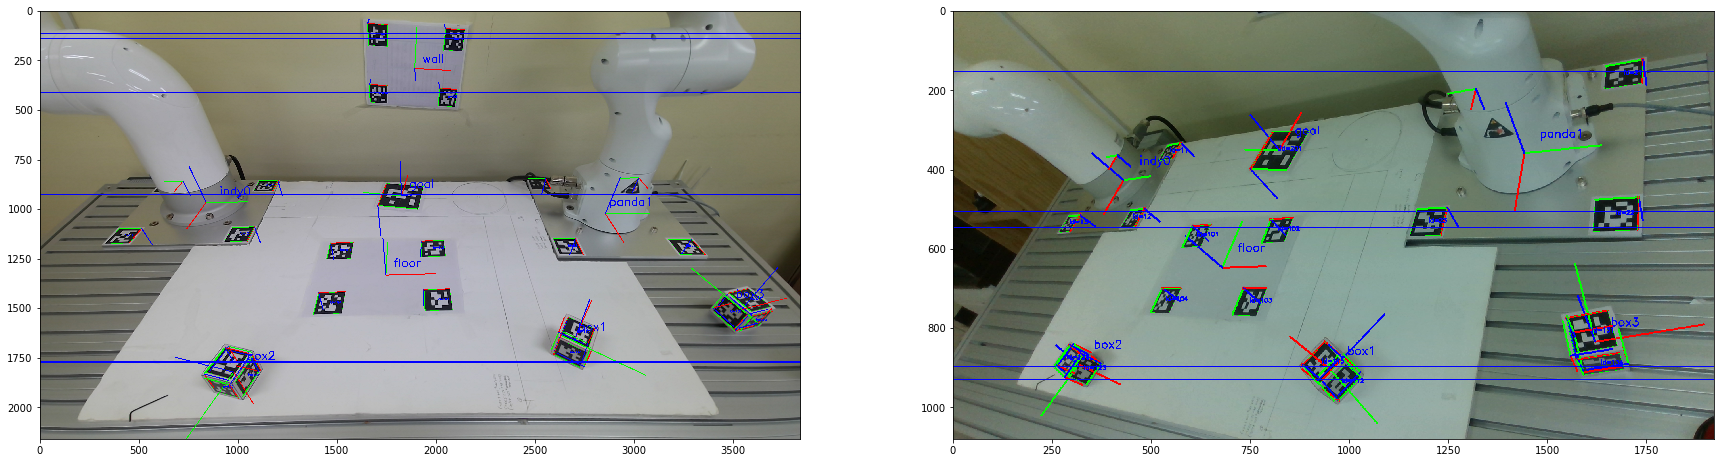

In [7]:
kn_image_out = draw_objects(color_image, aruco_map, objectPose_dict, corner_dict, *kn_config, axis_len=0.1)
rs_image_out = draw_objects(rs_image, aruco_map, {k:v for k,v in rs_objectPose_dict.items() if k != 'wall'}, rs_corner_dict, *rs_config, axis_len=0.1)
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
plt.imshow(kn_image_out[:,:,[2,1,0]])
plt.subplot(1,2,2)
plt.imshow(rs_image_out[:,:,[2,1,0]])

# Set robot

In [8]:
graph.reset_robots(connect_indy=False, connect_panda=False)

# Go home

In [9]:
if graph.connect_indy:
    graph.indy.connect_and(graph.indy.joint_move_to,np.rad2deg(ZERO_JOINT_POSE[graph.indy_idx]))
if graph.connect_panda:
    graph.panda.move_joint_interpolated(ZERO_JOINT_POSE[graph.panda_idx], N_div=300)
    graph.panda.set_k_gain(70)
    graph.panda.set_d_gain(7)

## Register binders

In [10]:
graph.register_binder(name='grip1', _type=Gripper2Tool, point=[0,0,0.112], link_name="panda1_hand", direction=[0,1,0])
graph.register_binder(name='grip0', _type=Gripper2Tool, point=[0,0,0.14], link_name="indy0_tcp", direction=[0,1,0])
graph.register_binder(name='floor', _type=PlacePlane, direction=[0,0,1])

# detect movable

In [11]:
objectPose_dict_mv, corner_dict_mv, color_image, aruco_map_mv = detect_objects(aruco_map, dictionary)
put_point_dict = graph.register_object_gen(objectPose_dict_mv, BINDER_DICT, OBJECT_DICT, 
                 ref_tuple=(REF_NAME, objectPose_dict[REF_NAME]), link_name="world")

# show markers

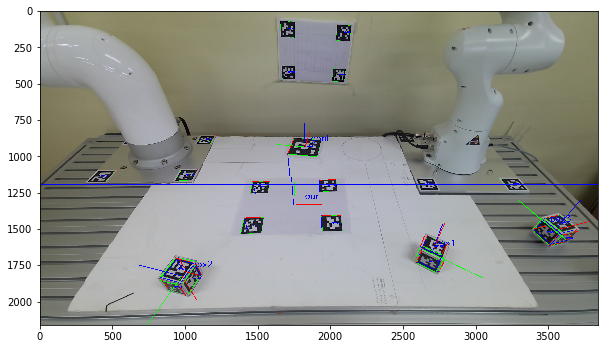

In [12]:
plt.figure(figsize=(10,8))
aruco_map_mv.update({'floor': aruco_map['floor']})
color_image_out = draw_objects(color_image, aruco_map_mv, objectPose_dict_mv, corner_dict_mv, *kn_config, axis_len=0.1)
plt.imshow(color_image_out[:,:,[2,1,0]])

In [13]:
# register_hexahedral_binder(graph, object_name='box1', _type=PlacePlane)
# register_hexahedral_binder(graph, object_name='box2', _type=PlacePlane)

# Set ui data

In [14]:
ui_broker.set_tables()

In [15]:
1

1

generate table - Handle
generate table - Geometry
generate table - Binder
generate table - Object
generate table - Marker
generate table - MarkerGroup
('saved on :', u'tmp.markergroup')
generate table - Handle
generate table - Binder
generate table - Marker
generate table - MarkerGroup
filname is empty
generate table - Handle
generate table - Binder
generate table - Geometry
generate table - Object
generate table - Marker
generate table - MarkerGroup
load: tmp.markergroup
add wall
add panda1
generate table - Handle
generate table - Binder
generate table - Geometry
generate table - Object
generate table - Marker
generate table - MarkerGroup


## Add/Remove geometry & object

In [ ]:
# graph.add_geometry(GeometryItem(gtype=GEOTYPE.BOX, name="test", link_name="world", center=(0,0,0), dims=(0.1,0.1,0.1)))
# graph.register_object("test", BoxAction, binding=("bottom_p", "floor"))

In [ ]:
# graph.remove_object("test")
# graph.remove_geometry(graph.ghnd.NAME_DICT["test"])

# Set Planner

In [ ]:
from pkg.planner.etasl.etasl import *
eplan = etasl_planner(joint_names = graph.joint_names, link_names = graph.link_names, urdf_path = graph.urdf_path)
graph.set_planner(eplan)

# Search Graph (Custom Robots)

In [ ]:
gtimer.reset()
graph.build_graph()
print(gtimer)

In [ ]:
objectPose_dict_mv, corner_dict_mv, color_image, aruco_map_mv = \
    detect_objects(MOVABLE_GENERATORS, aruco_map, dictionary)
objectPose_dict_mv.update({'floor': objectPose_dict['floor']})
xyz_rvec_mv_dict, put_point_dict, up_point_dict = calc_put_point(
    objectPose_dict_mv, MOVABLE_GENERATORS, OBJECT_DICT, ("floor", objectPose_dict["floor"]))
update_geometries(MOVABLE_GENERATORS.keys(), objectPose_dict_mv)
graph.show_pose(ZERO_JOINT_POSE)

In [ ]:
dt_sim = 0.04
T_step = 10
N_fullstep = int(T_step / dt_sim)
gtimer.reset()
initial_state = State(tuple([(oname, put_point_dict[oname],'floor') for oname in graph.object_list]), 
                      {oname: graph.object_dict[oname].object.get_offset_tf() for oname in graph.object_list}, 
                      (graph.get_real_robot_pose() if graph.connect_indy and graph.connect_panda 
                       else ZERO_JOINT_POSE))
binding_dict = match_point_binder(graph, initial_state, objectPose_dict_mv)
initial_state = State(tuple([(oname, put_point_dict[oname],binding_dict[oname]) for oname in graph.object_list]), 
                      {oname: graph.object_dict[oname].object.get_offset_tf() for oname in graph.object_list}, 
                      (graph.get_real_robot_pose() if graph.connect_indy and graph.connect_panda 
                       else ZERO_JOINT_POSE))
graph.set_object_state(initial_state)
graph.show_pose(ZERO_JOINT_POSE)

goal_nodes_1 = get_goal_nodes(initial_state.node, "box1", "goal_bd")
goal_nodes = []
for gnode in goal_nodes_1:
    goal_nodes += get_goal_nodes(gnode, "box2", "floor")
# goal_nodes = goal_nodes[3:4]

graph.search_graph_mp(
    initial_state = initial_state, goal_nodes = goal_nodes,
    tree_margin = 2, depth_margin = 2, joint_motion_num=10, 
    terminate_on_first = True, N_search = 100, N_loop=1000,
    display=False, dt_vis=dt_sim/4, verbose = True, print_expression=False, error_skip=0, traj_count=3,
    **dict(N=N_fullstep, dt=dt_sim, vel_conv=0.5e-2, err_conv=1e-3))

schedule_dict = graph.find_schedules()
schedule_sorted = graph.sort_schedule(schedule_dict)

In [ ]:
print(gtimer)

In [ ]:
graph.quiver_snodes()

# Replay schedule

In [41]:
N_fullstep = 500
# dt_sim = 0.04
for schedule in schedule_sorted:
    print(schedule)
for schedule, i_s in zip(schedule_sorted[:], range(len(schedule_sorted))):
    traj, end_state, error, success = graph.test_transition(
        graph.snode_dict[0].state, graph.snode_dict[0].state, 
        N=10, dt=dt_sim, vel_conv=1e-2, err_conv=5e-4, print_expression=False)
    timer.sleep(0.1)
#     try:
    e = graph.replay(schedule, N=N_fullstep, dt=dt_sim, 
                     vel_conv=1e-3, err_conv=1e-3, error_skip=0)
#     except Exception as e:
#         print(e)

[0, 1, 8]
[0, 4, 9]
[0, 1, 10]
[0, 7, 12]

--------------------
1-(('box1', 'top_g', 'grip1'), ('box2', 'right_p', 'floor'))

--------------------
8-(('box1', 'left_p', 'goal_bd'), ('box2', 'right_p', 'floor'))

--------------------
4-(('box1', 'bottom_g', 'grip0'), ('box2', 'right_p', 'floor'))

--------------------
9-(('box1', 'back_p', 'goal_bd'), ('box2', 'right_p', 'floor'))

--------------------
1-(('box1', 'top_g', 'grip1'), ('box2', 'right_p', 'floor'))

--------------------
10-(('box1', 'front_p', 'goal_bd'), ('box2', 'right_p', 'floor'))

--------------------
7-(('box1', 'bottom_g', 'grip1'), ('box2', 'back_g', 'grip0'))

--------------------
12-(('box1', 'left_p', 'goal_bd'), ('box2', 'bottom_p', 'floor'))


# Execute traj online

In [35]:
schedule = schedule_sorted[0]
snode_schedule = graph.idxSchedule2SnodeScedule(schedule, ZERO_JOINT_POSE)
graph.set_planner(eplan, bind=False)

with DynamicDetector(eplan.online_names, aruco_map, dictionary, rs_config, T_c12, objectPose_dict['floor']) as dynamic_detector, \
        RvizPublisher(graph, eplan.online_names) as rviz_pub:
    e_sim = graph.execute_schedule_online(snode_schedule, eplan, control_freq=DEFAULT_TRAJ_FREQUENCY, playback_rate=0.5,
                                  vel_conv=0, err_conv=1e-3, T_step = 100, on_rviz=True, 
                                  dynamic_detector=dynamic_detector, rviz_pub=rviz_pub, obs_K="40")

exit
exit
exit


# onestep

In [36]:
loop_process = graph
loop_process.stop_now = False
while not loop_process.stop_now:
    print("wait for button input")
    graph.indy.connect_and(graph.indy.wait_di, 16)
    if loop_process.stop_now:
        break
    kn_config, rs_config, T_c12 = calibrate_stereo(aruco_map, dictionary)
    objectPose_dict_mv, corner_dict_mv, color_image, aruco_map_mv = \
        detect_objects(MOVABLE_GENERATORS, aruco_map, dictionary)
    objectPose_dict_mv.update({'floor': objectPose_dict['floor']})
    xyz_rvec_mv_dict, put_point_dict, up_point_dict = calc_put_point(
        objectPose_dict_mv, MOVABLE_GENERATORS, OBJECT_DICT, ("floor", objectPose_dict["floor"]))
    update_geometries(MOVABLE_GENERATORS.keys(), objectPose_dict_mv)
    graph.show_pose(ZERO_JOINT_POSE)

    dt_sim = 0.04
    T_step = 10
    N_fullstep = int(T_step / dt_sim)
    gtimer.reset()
    initial_state = State(tuple([(oname, put_point_dict[oname],'floor') for oname in graph.object_list]), 
                          {oname: graph.object_dict[oname].object.get_offset_tf() for oname in graph.object_list}, 
                          (graph.get_real_robot_pose() if graph.connect_indy and graph.connect_panda 
                           else ZERO_JOINT_POSE))
    binding_dict = match_point_binder(graph, initial_state, objectPose_dict_mv)
    initial_state = State(tuple([(oname, put_point_dict[oname],binding_dict[oname]) for oname in graph.object_list]), 
                          {oname: graph.object_dict[oname].object.get_offset_tf() for oname in graph.object_list}, 
                          (graph.get_real_robot_pose() if graph.connect_indy and graph.connect_panda 
                           else ZERO_JOINT_POSE))
    graph.set_object_state(initial_state)
    graph.show_pose(ZERO_JOINT_POSE)

    goal_nodes_1 = get_goal_nodes(initial_state.node, "box1", "goal_bd")
    goal_nodes = []
    for gnode in goal_nodes_1:
        goal_nodes += get_goal_nodes(gnode, "box2", "floor")
    # goal_nodes = goal_nodes[3:4]

    graph.search_graph_mp(
        initial_state = initial_state, goal_nodes = goal_nodes, swept_volume_test_jmotion=False,
        tree_margin = 2, depth_margin = 2, joint_motion_num=10, 
        terminate_on_first = True, N_search = 100, N_loop=1000,
        display=False, dt_vis=dt_sim/40, verbose = True, print_expression=False, error_skip=0,
        **dict(N=N_fullstep, dt=dt_sim, vel_conv=1e-3, err_conv=1e-3, N_step=N_fullstep))

    schedule_dict = graph.find_schedules()
    schedule_sorted = graph.sort_schedule(schedule_dict)
    print(gtimer)
    schedule_dict = graph.find_schedules()
    schedule_sorted = graph.sort_schedule(schedule_dict)

    schedule = schedule_sorted[0]
    state_schedule = graph.idxSchedule2stateScedule(schedule, ZERO_JOINT_POSE)
    obs_names = ["box3"]

    with DynamicDetector(obs_names, aruco_map, dictionary, rs_config, T_c12, objectPose_dict['floor']) as dynamic_detector, \
            RvizPublisher(graph, obs_names) as rviz_pub:
        graph.execute_schedule_online(state_schedule, control_freq=DEFAULT_TRAJ_FREQUENCY, playback_rate=0.5,
                                      vel_conv=1e-2, err_conv=1e-3, T_step = 100, on_rviz=False, 
                                      obs_names=obs_names, dynamic_detector=dynamic_detector, rviz_pub=rviz_pub)
print("===========================================")
print("=================KILLED====================")
print("===========================================")

wait for button input


AttributeError: 'NoneType' object has no attribute 'connect_and'

In [ ]:
def loop_process():
    loop_process.stop_now = False
    while not loop_process.stop_now:
        print("wait for button input")
        graph.indy.connect_and(graph.indy.wait_di, 16)
        if loop_process.stop_now:
            break
        kn_config, rs_config, T_c12 = calibrate_stereo(aruco_map, dictionary)
        objectPose_dict_mv, corner_dict_mv, color_image, aruco_map_mv = \
            detect_objects(MOVABLE_GENERATORS, aruco_map, dictionary)
        objectPose_dict_mv.update({'floor': objectPose_dict['floor']})
        xyz_rvec_mv_dict, put_point_dict, up_point_dict = calc_put_point(
            objectPose_dict_mv, MOVABLE_GENERATORS, OBJECT_DICT, ("floor", objectPose_dict["floor"]))
        update_geometries(MOVABLE_GENERATORS.keys(), objectPose_dict_mv)
        graph.show_pose(ZERO_JOINT_POSE)
        
        dt_sim = 0.04
        T_step = 10
        N_fullstep = int(T_step / dt_sim)
        gtimer.reset()
        initial_state = State(tuple([(oname, put_point_dict[oname],'floor') for oname in graph.object_list]), 
                              {oname: graph.object_dict[oname].object.get_offset_tf() for oname in graph.object_list}, 
                              (graph.get_real_robot_pose() if graph.connect_indy and graph.connect_panda 
                               else ZERO_JOINT_POSE))
        binding_dict = match_point_binder(graph, initial_state, objectPose_dict_mv)
        initial_state = State(tuple([(oname, put_point_dict[oname],binding_dict[oname]) for oname in graph.object_list]), 
                              {oname: graph.object_dict[oname].object.get_offset_tf() for oname in graph.object_list}, 
                              (graph.get_real_robot_pose() if graph.connect_indy and graph.connect_panda 
                               else ZERO_JOINT_POSE))
        graph.set_object_state(initial_state)
        graph.show_pose(ZERO_JOINT_POSE)

        goal_nodes_1 = get_goal_nodes(initial_state.node, "box1", "goal_bd")
        goal_nodes = []
        for gnode in goal_nodes_1:
            goal_nodes += get_goal_nodes(gnode, "box2", "floor")
        # goal_nodes = goal_nodes[3:4]

        graph.search_graph_mp(
            initial_state = initial_state, goal_nodes = goal_nodes, swept_volume_test_jmotion=False,
            tree_margin = 2, depth_margin = 2, joint_motion_num=10, 
            terminate_on_first = True, N_search = 100, N_loop=1000,
            display=False, dt_vis=dt_sim/40, verbose = True, print_expression=False, error_skip=0,
            **dict(N=N_fullstep, dt=dt_sim, vel_conv=1e-3, err_conv=1e-3, N_step=N_fullstep))

        schedule_dict = graph.find_schedules()
        schedule_sorted = graph.sort_schedule(schedule_dict)
        print(gtimer)
        schedule_dict = graph.find_schedules()
        schedule_sorted = graph.sort_schedule(schedule_dict)

        schedule = schedule_sorted[0]
        state_schedule = graph.idxSchedule2stateScedule(schedule, ZERO_JOINT_POSE)
        obs_names = ["box3"]

        with DynamicDetector(obs_names, aruco_map, dictionary, rs_config, T_c12, objectPose_dict['floor']) as dynamic_detector, \
                RvizPublisher(graph, obs_names) as rviz_pub:
            graph.execute_schedule_online(state_schedule, control_freq=DEFAULT_TRAJ_FREQUENCY, playback_rate=0.5,
                                          vel_conv=0.2e-2, err_conv=1e-3, T_step = 100, on_rviz=False, 
                                          obs_names=obs_names, dynamic_detector=dynamic_detector, rviz_pub=rviz_pub)
    print("===========================================")
    print("=================KILLED====================")
    print("===========================================")
t_loop = Thread(target=loop_process)
t_loop.start()

In [ ]:
loop_process.stop_now=True

In [ ]:
t_loop.is_alive()

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
ax = plt.plot(qcount_indy_list)
ax = plt.plot(qcount_panda_list)
plt.subplot(1,2,2)
ax = plt.plot(looptime_list)
print(gtimer)

# Going back

In [ ]:
e_POS = e_POS_list[0]
self.panda.move_joint_interpolated(
    e_POS[0, graph.panda_idx], N_step=500, N_div=500)

In [ ]:
e_POS = e_POS_list[0]
if hasattr(graph, 'indy'):
    graph.indy.joint_move_to(np.rad2deg(e_POS[0,graph.indy_idx]))

In [ ]:
self.reset_panda()

In [4]:
'x' in [u'x', u'y']

True

## test unavailable binder

In [50]:
from_state = graph.snode_dict[2].state
to_state = from_state.copy()
print(to_state.node)
print(sorted(graph.binder_dict.keys()))

(('box1', 'front_p', 'grip1'), ('box2', 'front_p', 'grip0'))
['box1_back', 'box1_bottom', 'box1_front', 'box1_left', 'box1_right', 'box1_top', 'box2_back', 'box2_bottom', 'box2_front', 'box2_left', 'box2_right', 'box2_top', 'floor', 'goal_bd', 'grip0', 'grip1']


In [47]:
to_state.node = (('box1', 'back_p', 'box2_right'), ('box2', 'front_p', 'grip0'))

In [48]:
traj, new_state, error, succ = graph.test_transition(from_state, to_state, display=True, N=N_fullstep, dt=dt_sim, vel_conv=1e-3, err_conv=1e-3)

===============Unavailable binder====================


# test mesh

In [ ]:
from pkg.gjk import *

In [ ]:
Q1 = ZERO_JOINT_POSE
Q2 = ZERO_JOINT_POSE - 0.1

gtimer.reset()

gtimer.tic("svt")
swept_volume_test(Q1, Q2, graph.fixed_collision_items_list+graph.movable_collision_items_list, 
                  graph.joint_names, graph.urdf_content)
gtimer.toc("svt")

In [ ]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as mplot3d

fig = plt.figure(figsize=(15, 5))

idx_col = 205

sub = fig.add_subplot(1, 1, 1, projection="3d")
x, y, z = np.transpose(vtx2_list[idx1_list[idx_col]])
sub.plot(x, y, z, '-o')
x, y, z = np.transpose(vtx2_list[idx2_list[idx_col]])
print(GeometryItem.GLOBAL_GEO_LIST[idx1_list[idx_col]].name)
print(GeometryItem.GLOBAL_GEO_LIST[idx2_list[idx_col]].name)
sub.plot(x, y, z, '-o')
# sub.view_init(0, 90)

In [ ]:
# np.save("vtx_list", vtx_list)
# np.save("radius_list", radius_list)
# np.save("idx1_list", idx1_list)
# np.save("idx2_list", idx2_list)

# test time

In [ ]:
gtimer.reset()
found_vec = []
for _ in range(10):
    objectPose_dict_mv, corner_dict_mv, color_image, aruco_map_mv = \
        detect_objects(MOVABLE_GENERATORS, aruco_map, dictionary)
    objectPose_dict_mv.update({'floor': objectPose_dict['floor']})
    xyz_rvec_mv_dict, put_point_dict, up_point_dict = calc_put_point(
        objectPose_dict_mv, MOVABLE_GENERATORS, OBJECT_DICT, ("floor", objectPose_dict["floor"]))
    update_geometries(MOVABLE_GENERATORS.keys(), objectPose_dict_mv)
    graph.show_pose(ZERO_JOINT_POSE)
    
    dt_sim = 0.04
    T_step = 10
    N_fullstep = int(T_step / dt_sim)
    initial_state = State(tuple([(oname, put_point_dict[oname],'floor') for oname in graph.object_list]), 
                          {oname: graph.object_dict[oname].object.get_offset_tf() for oname in graph.object_list}, 
                          (graph.get_real_robot_pose() if graph.connect_indy and graph.connect_panda 
                           else ZERO_JOINT_POSE))

    goal_nodes = get_goal_nodes(initial_state, "box1", "goal_bd")
    # goal_nodes = goal_nodes[3:4]

    graph.search_graph_mp(
        initial_state = initial_state, goal_nodes = goal_nodes, swept_volume_test_jmotion=True,
        tree_margin = 2, depth_margin = 2, joint_motion_num=20, 
        terminate_on_first = True, N_search = 100, N_loop=1000,
        display=False, dt_vis=dt_sim/40, verbose = True, print_expression=False, error_skip=0,
        **dict(N=N_fullstep, dt=dt_sim, vel_conv=1e-2, err_conv=1e-3, N_step=N_fullstep))

    schedule_dict = graph.find_schedules()
    schedule_sorted = graph.sort_schedule(schedule_dict)
    found_vec.append(len(schedule_sorted)>0)
print(gtimer)

In [ ]:
print("Success rate: {} %".format(np.mean(found_vec)*100))
print(gtimer)

In [ ]:
# SVT CASE
# Success rate: 100.0 %
# show_pose: 	637.0 ms/30 = 21.22 ms (18.16/27.518)
# search_graph_mp: 	99415.0 ms/30 = 3313.844 ms (1712.408/4521.561)
# init_search: 	57.0 ms/30 = 1.908 ms (1.497/7.065)
# score_graph: 	29.0 ms/240 = 0.122 ms (0.086/0.272)
# reset_valid_node: 	14.0 ms/6030 = 0.002 ms (0.001/0.025)
# check_goal: 	4.0 ms/6177 = 0.001 ms (0.0/0.021)
# get_valid_neighbor: 	6.0 ms/540 = 0.011 ms (0.002/3.62)
# add_node_queue_leafs: 	113.0 ms/30 = 3.767 ms (2.884/5.323)
# find_schedules: 	28.0 ms/30 = 0.948 ms (0.604/1.509)
# sort_schedule: 	0.0 ms/30 = 0.01 ms (0.007/0.022)

In [ ]:
# NO SVT CASE
# Success rate: 100.0 %
# show_pose: 	609.0 ms/30 = 20.284 ms (17.837/26.163)
# search_graph_mp: 	96204.0 ms/30 = 3206.813 ms (1566.82/4633.293)
# init_search: 	53.0 ms/30 = 1.753 ms (1.495/2.953)
# score_graph: 	28.0 ms/240 = 0.116 ms (0.088/0.312)
# reset_valid_node: 	14.0 ms/6030 = 0.002 ms (0.001/0.022)
# check_goal: 	4.0 ms/6174 = 0.001 ms (0.0/0.015)
# get_valid_neighbor: 	2.0 ms/540 = 0.004 ms (0.002/0.026)
# add_node_queue_leafs: 	109.0 ms/30 = 3.65 ms (2.816/4.925)
# find_schedules: 	28.0 ms/30 = 0.941 ms (0.617/2.113)
# sort_schedule: 	0.0 ms/30 = 0.01 ms (0.007/0.015)